# Automatic BSPF AnalysisData

Creates automatic event plots based on catalog 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo


In [5]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [6]:
def __process_xpfo(config, st, inv):

    ii_pfo = st.copy()

#     pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
#     ii_pfo.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo.detrend("demean")

    ## remove response
#     ii_pfo.remove_response(inventory=inv, 
#     #                        pre_filt=pre_filt, 
#                            output="VEL",
#     #                        water_level=60, 
#                            plot=False)

    ## taper 
    ii_pfo.taper(0.1)

    ## bandpass
    ii_filter = ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ## adjust channel names
    for tr in ii_pfo:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")
    
    return ii_pfo

In [7]:
def __makeplot(config, st):

    
    st_in = st.copy()
    
    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st_in):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)
    
    plt.show();
    del st_in
    return fig

In [8]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()
    
    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [9]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace
    
    t_ref = reference_stream[0]
    
    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t
        
    return empty

## Configurations

In [92]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
# config['outpath_figs'] = data_path+"BSPF/figures/triggered_all/"

## path for output data
config['outpath_data'] = data_path+"BSPF/data/" 

config['path_to_mseed'] = data_path+"BSPF/data/waveforms/" 

## blueSeis sensor (@200Hz)
# config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
# config['seed_seismometer1'] = "II.PFO.10.BH*" 

## STS2 next to BlueSeis (@200Hz)
# config['seed_seismometer2'] = "PY.PFOIX..HH*" 

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230615_triggered.pkl"

## Event Info

In [11]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## reset the index
events.reset_index(inplace=True)

## set column for origin time
events.rename(columns = {'index':'origin'}, inplace = True)

## add column for hypocenter distance
events['Hdistance_km'] = np.sqrt(events['distances_km']**2+(events['depth']/1000)**2)

In [13]:
events

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,cosum,backazimuth,distances_km,Hdistance_km
0,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,0.00,2022-10-02T03:25:19.344538Z,4.0,19.364710,14.850966,16.887652
1,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,132173.53,2022-10-03T16:08:19.219538Z,6.0,128.765512,55.472148,55.993067
2,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,132173.53,2022-10-03T16:08:19.219538Z,6.0,128.765512,55.472148,55.993067
3,2022-10-05 15:39:13.690,33.494500,-116.509500,12410.0,0.50,ml,303237.25,2022-10-05T15:39:17.944539Z,4.0,21.277323,13.825658,18.578399
4,2022-10-07 22:45:05.470,33.041333,-116.354667,11790.0,3.47,mlr,501589.03,2022-10-07T22:45:15.894539Z,6.0,351.575554,63.835594,64.915231
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2023-05-24 19:11:52.210,33.952667,-116.645333,11420.0,2.22,ml,20274395.77,2023-05-24T19:11:59.335000Z,4.0,155.073931,41.815491,43.346876
96,2023-05-31 23:27:27.570,33.950667,-116.642833,16340.0,2.35,ml,20894531.13,2023-05-31T23:27:34.805000Z,4.0,155.235515,41.517082,44.616854
97,2023-06-04 04:43:02.890,33.140667,-116.526500,7720.0,3.16,ml,21172666.45,2023-06-04T04:43:11.320000Z,5.0,7.210330,52.543371,53.107479
98,2023-06-07 06:03:42.030,33.965667,-116.946000,7240.0,2.58,ml,21436705.59,2023-06-07T06:03:52.075000Z,4.0,130.780515,60.123060,60.557410


## RUN LOOP

In [14]:
def __compute_Amax(st_in, out_lst):
     
    st_in = st_in.sort()

    st_in = st_in.detrend("linear")
    
    out, header = [], []
    for tr in st_in:
        out.append(max(abs(tr.data)))
        header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}_Amax")
        
    out_lst.append(out)
    return out_lst, header

In [15]:
def __compute_SNR(st_in, out_lst, trigger_time, win_length_sec=10, plot=False):

    from numpy import nanmean, sqrt
    
    st_in = st_in.sort()
    
    if plot:
        fig, ax = plt.subplots(len(st_in),1, figsize=(15,15))
    
    out, header = [], []
    for i, tr in enumerate(st_in):

        t_rel_sec = trigger_time-tr.stats.starttime
        
        df = tr.stats.sampling_rate 

        NN = int(df * win_length_sec) ## samples

        t_rel_spl = t_rel_sec*df ## samples

        t_offset = df * 2 ## samples

        noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
        signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)

        out.append(sqrt(signal/noise))
        header.append(f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}_SNR")
        
        if plot:
            ax[i].plot(tr.data)

            ax[i].axvline(t_rel_spl, color="red")
            ax[i].axvline(t_rel_spl+NN, color="red")

            ax[i].axvline(t_rel_spl, color="g")
            ax[i].axvline(t_rel_spl-NN, color="g")
        
    out_lst.append(out)
    
    return out_lst, header

In [16]:
config['mseed_files'] = sorted([file for file in os.listdir(config['path_to_mseed'])])
print(config['mseed_files'])

['000_20221002_032516.mseed', '001_20221003_160809.mseed', '002_20221003_160809.mseed', '003_20221005_153913.mseed', '004_20221007_224505.mseed', '005_20221008_025233.mseed', '006_20221015_051734.mseed', '007_20221017_052528.mseed', '008_20221023_092458.mseed', '009_20221025_035530.mseed', '010_20221025_035530.mseed', '011_20221025_122941.mseed', '012_20221026_021458.mseed', '013_20221026_081415.mseed', '014_20221119_041541.mseed', '015_20221201_152829.mseed', '016_20221221_004614.mseed', '017_20221221_004614.mseed', '018_20221225_084038.mseed', '019_20221225_185313.mseed', '020_20221231_104543.mseed', '021_20221231_121226.mseed', '022_20221231_164007.mseed', '023_20230102_032018.mseed', '024_20230105_100033.mseed', '025_20230105_100033.mseed', '026_20230105_232623.mseed', '027_20230109_165936.mseed', '028_20230109_194256.mseed', '029_20230111_185920.mseed', '030_20230111_185920.mseed', '031_20230112_173638.mseed', '032_20230115_095854.mseed', '033_20230115_095854.mseed', '034_20230118

In [30]:

out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["BAZ"] = events.backazimuth
out_df["Edistance"] = events.distances_km
out_df["Hdistance"] = events.Hdistance_km


data_amax, data_snr = [], []
for jj, event in enumerate(config['mseed_files'][:2]):

    print(f"\n -> {jj} {events.origin[jj]} ")
    
    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    

    st = obs.read(config['path_to_mseed']+event)

    ## processing data stream
    st = st.detrend("linear")
    st = st.taper(0.01)
    st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)
    
    
    ## compute maximal amplitude values (PGA and PGR)
    data_amax, header_amax = __compute_Amax(st, data_amax)

    ## compute signal-to-noise ratios
    data_snr, header_snr = __compute_SNR(st, data_snr, events.trigger_time[jj], win_length_sec=10)
    

## _______________________________________

df_amax = pd.DataFrame(columns=header_amax)

for i, row in enumerate(data_amax):
    if len(row) == 12:
        df_amax.loc[len(df_amax)] = row    
    else:
        df_amax.loc[len(df_amax)] = np.ones(12)*np.nan

df_amax_out = pd.concat([out_df, df_amax], axis=1, ignore_index=False, sort=False)

df_amax_out.to_pickle(config['outpath_data']+"bspf_analysisdata_amax.pkl")
print(f" -> writing: {config['outpath_data']}bspf_analysisdata_amax.pkl")

## _______________________________________ 
    
df_snr = pd.DataFrame(columns=header_snr)

for row in data_snr:
    if len(row) == 12:
        df_snr.loc[len(df_amax)] = row    
    else:
        df_snr.loc[len(df_amax)] = np.ones(12)*np.nan
        
df_snr_out = pd.concat([out_df, df_snr], axis=1, ignore_index=False, sort=False)


df_snr_out.to_pickle(config['outpath_data']+"bspf_analysisdata_snr.pkl")
print(f" -> writing: {config['outpath_data']}bspf_analysisdata_snr.pkl")


## End of File


 -> 0 2022-10-02 03:25:16.440000 

 -> 1 2022-10-03 16:08:09.970000 
 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_amax.pkl
 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_snr.pkl


In [62]:
def __rolling_average(arr, win_size=5):
    
    from numpy import ones, array
    from scipy.signal import convolve, hanning
    
    data = array(arr)
    window = ones(win_size)/float(win_size)
    window = hanning(win_size)/float(win_size)
    rolling_average = convolve(data, window, mode='valid')

    return rolling_average

In [164]:
baz = out_df.loc[jj].BAZ

from obspy.signal.rotate import rotate_ne_rt

st_acc = st.select(station="PFO").copy()
st_rot = st.select(station="BSPF").copy()

st_acc.filter("bandpass", freqmin=10, freqmax=18, zerophase=True, corners=4)
st_rot.filter("bandpass", freqmin=10, freqmax=18, zerophase=True, corners=4)

r_acc, t_acc = rotate_ne_rt(st_acc.select(channel='*N')[0].data, 
                            st_acc.select(channel='*E')[0].data,
                            baz
                            )

r_rot, t_rot = rotate_ne_rt(st_rot.select(channel='*N')[0].data, 
                            st_rot.select(channel='*E')[0].data,
                            baz
                            )

z_acc = st_acc.select(channel="*Z")[0].data

v_rayleigh = abs(z_acc) / abs(t_rot)

(0.0, 5000.0)

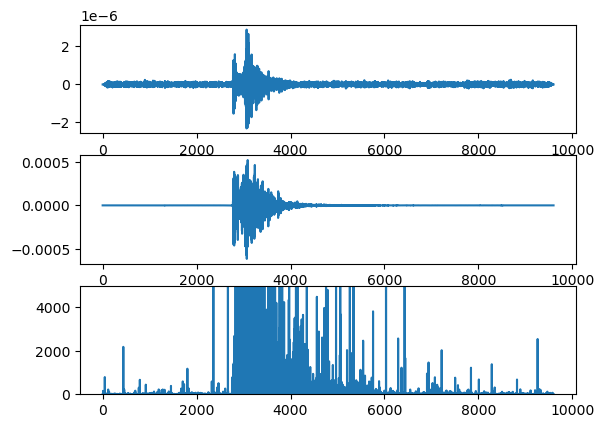

In [165]:
fig, ax = plt.subplots(3,1)

ax[0].plot(t_rot)


ax[1].plot(z_acc)

ax[2].plot(v_rayleigh)

ax[2].set_ylim(0,5000)

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (50) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


(0.0, 5000.0)

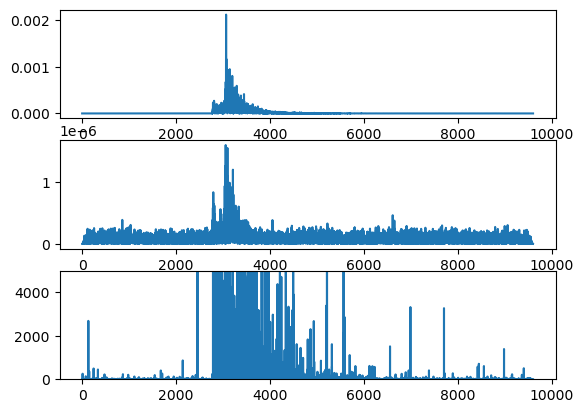

In [74]:
st0 = st.copy()

st0.filter('bandpass', freqmin=5, freqmax=50, zerophase=True, corners=4)

xpfo_n = abs(st0.select(station="PFO", channel="*N")[0].data)
bspf_z = abs(st0.select(station="BSPF", channel="*Z")[0].data)

# a_n = __rolling_average(xpfo_n, win_size=3)
# w_z = __rolling_average(bspf_z, win_size=3)

v1 = 0.5*xpfo_n/bspf_z
# v2 = 0.5*a_n/w_z

fig, ax = plt.subplots(3,1)

ax[0].plot(xpfo_n)
# ax[0].plot(a_n)


ax[1].plot(bspf_z)
# ax[1].plot(w_z)

ax[2].plot(v1)
# ax[2].plot(v2)

ax[2].set_ylim(0,5000)

128.76551217314835

## Testing Signal-to-Noise ratios

In [109]:
# from numpy import nanmean, sqrt

# win_length_sec = 10 ## seconds

# t_trigger = events.trigger_time[jj]
# t_rel_sec = t_trigger-config['tbeg']
# fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

# for i, tr in enumerate(st0):
    
#     df = tr.stats.sampling_rate 
    
#     NN = int(df * win_length_sec) ## samples
    
#     t_rel_spl = t_rel_sec*df ## samples
    
#     t_offset = df * 2 ## samples
    
#     noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
#     signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)
    
#     SNR = sqrt(signal/noise)
    
    
       
#     ax[i].plot(tr.data)
    
#     ax[i].axvline(t_rel_spl, color="red")
#     ax[i].axvline(t_rel_spl+NN, color="red")

#     ax[i].axvline(t_rel_spl, color="g")
#     ax[i].axvline(t_rel_spl-NN, color="g")

#     print(SNR)
    
# plt.show();    


KeyError: 'tbeg'

## Test Back Azimuth

In [86]:
from functions.compute_backazimuth import __compute_backazimuth

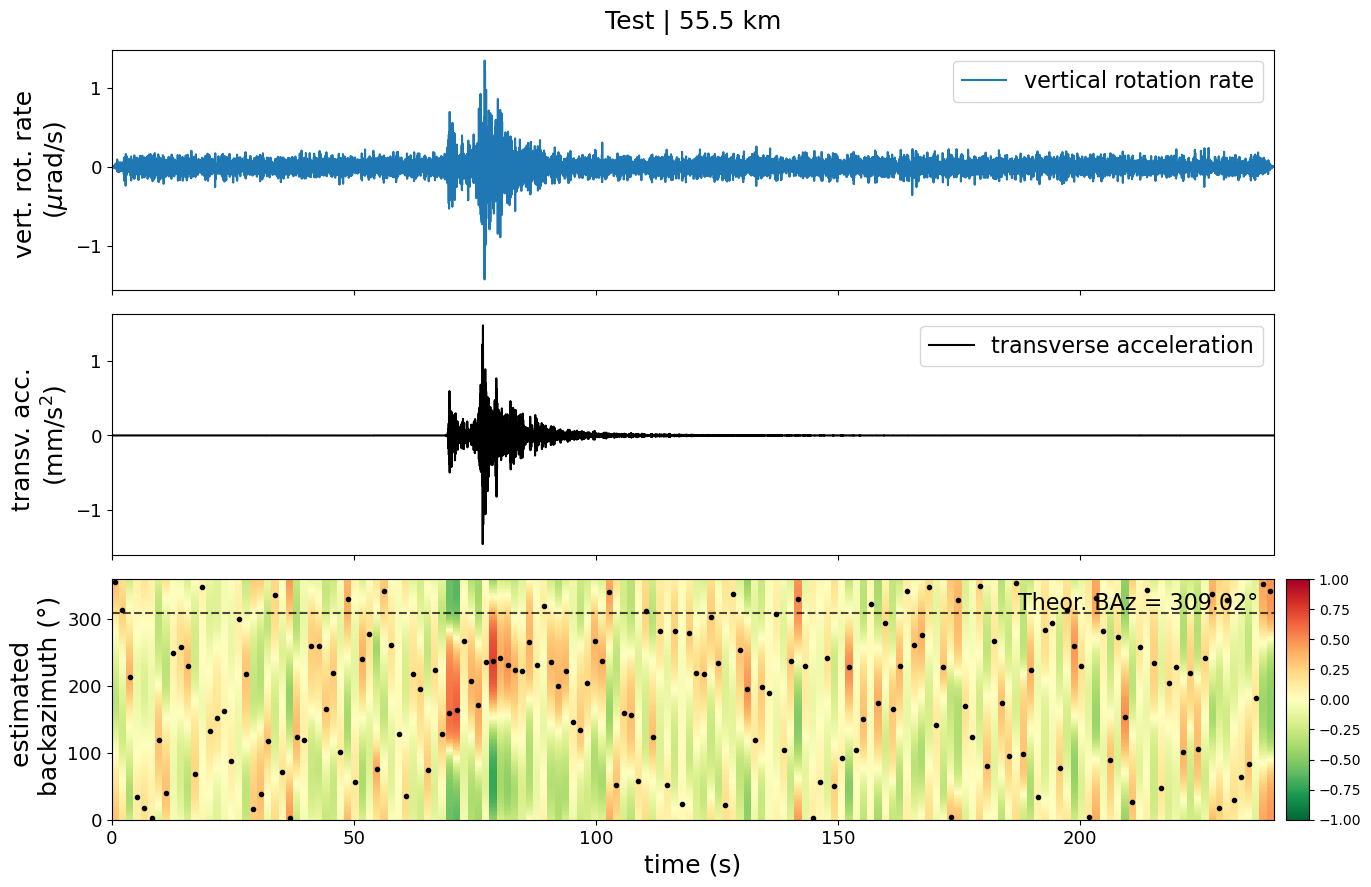

{'baz_mesh': [array([[   0.75,    2.25,    3.75, ...,  236.25,  237.75,  239.25],
         [   0.75,    2.25,    3.75, ...,  236.25,  237.75,  239.25],
         [   0.75,    2.25,    3.75, ...,  236.25,  237.75,  239.25],
         ..., 
         [   0.75,    2.25,    3.75, ...,  236.25,  237.75,  239.25],
         [   0.75,    2.25,    3.75, ...,  236.25,  237.75,  239.25],
         [   0.75,    2.25,    3.75, ...,  236.25,  237.75,  239.25]]),
  array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   2.,    2.,    2., ...,    2.,    2.,    2.],
         [   4.,    4.,    4., ...,    4.,    4.,    4.],
         ..., 
         [ 354.,  354.,  354., ...,  354.,  354.,  354.],
         [ 356.,  356.,  356., ...,  356.,  356.,  356.],
         [ 358.,  358.,  358., ...,  358.,  358.,  358.]])],
 'baz_corr': array([[ 0.31264518,  0.17534916, -0.23849699, ..., -0.14337617,
          0.4144427 ,  0.46879321],
        [ 0.31114055,  0.17062976, -0.25138479, ..., -0.14354185,
     

In [142]:
st_acc = st.select(station="PFO").copy()
st_rot = st.select(station="BSPF").copy()

st_acc.filter('bandpass', freqmin=8, freqmax=18, zerophase=True, corners=4)
st_rot.filter('bandpass', freqmin=8, freqmax=18, zerophase=True, corners=4)

config2 = {}
config2['tbeg'] = st_acc[0].stats.starttime
config2['tend'] = st_acc[0].stats.endtime
config2['station_latitude'] = config['BSPF_lat']
config2['station_longitude'] = config['BSPF_lon']
config2['step'] = 2
config2['win_length_sec'] = 1.5
config2['overlap'] = 0.1
config2['eventtime'] = obs.UTCDateTime(out_df['Torigin'].iloc[jj])
config2['title'] = "Test"

__compute_backazimuth(    
                        st_acc,
                        st_rot,
                        config2,
                        wave_type='love',
                        event=None,
                        plot=True,
                        show_details=False,
                      )
